In [1]:
import argparse
import scipy
from scipy import ndimage
import numpy as np
import sys

import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
from torch.utils import data, model_zoo
from model.deeplab_multi import Res_Deeplab
from dataset.cityscapes_dataset import cityscapesDataSet
from collections import OrderedDict
import os
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn as nn
from dataset.gta5_dataset import GTA5DataSet



# config

In [2]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

MODEL = 'DeepLab'
BATCH_SIZE = 1
ITER_SIZE = 1
NUM_WORKERS = 4
DATA_DIRECTORY = './data/GTA5'
DATA_LIST_PATH = './dataset/gta5_list/train.txt'
IGNORE_LABEL = 255
INPUT_SIZE = '1280,720'
DATA_DIRECTORY_TARGET = './data/Cityscapes/data'
DATA_LIST_PATH_TARGET = './dataset/cityscapes_list/train.txt'
INPUT_SIZE_TARGET = '1024,512'
LEARNING_RATE = 2.5e-4
MOMENTUM = 0.9
NUM_CLASSES = 19
NUM_STEPS = 250000
NUM_STEPS_STOP = 100000  # early stopping
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM = 'http://vllab.ucmerced.edu/ytsai/CVPR18/DeepLab_resnet_pretrained_init-f81d91e8.pth'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 5000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005

LEARNING_RATE_D = 1e-4
LAMBDA_SEG = 0.1
LAMBDA_ADV_TARGET1 = 0.0002
LAMBDA_ADV_TARGET2 = 0.001

TARGET = 'cityscapes'
SET = 'train'
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]

In [3]:
def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

# set arg parser

In [4]:
def set_arguments(args):
    """Parse all the arguments provided from the CLI.

    Returns:
      A list of parsed arguments.
    """
    parser = argparse.ArgumentParser(description="DeepLab-ResNet Network")
    parser.add_argument("--data-dir", type=str, default=DATA_DIRECTORY,
                        help="Path to the directory containing the Cityscapes dataset.")
    parser.add_argument("--data-dir-target", type=str, default=DATA_DIRECTORY_TARGET,
                        help="Path to the directory containing the target dataset.")
    parser.add_argument("--data-list", type=str, default=DATA_LIST_PATH,
                        help="Path to the file listing the images in the dataset.")
    parser.add_argument("--model", type=str, default=MODEL,
                        help="available options : DeepLab")
    parser.add_argument("--target", type=str, default=TARGET,
                        help="available options : cityscapes")
    parser.add_argument("--batch-size", type=int, default=BATCH_SIZE,
                        help="Number of images sent to the network in one step.")
    parser.add_argument("--iter-size", type=int, default=ITER_SIZE,
                        help="Accumulate gradients for ITER_SIZE iterations.")
    parser.add_argument("--num-workers", type=int, default=NUM_WORKERS,
                        help="number of workers for multithread dataloading.")
    parser.add_argument("--ignore-label", type=int, default=IGNORE_LABEL,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--input-size", type=str, default=INPUT_SIZE,
                        help="Comma-separated string with height and width of source images.")
    parser.add_argument("--data-list-target", type=str, default=DATA_LIST_PATH_TARGET,
                        help="Path to the file listing the images in the target dataset.")
    parser.add_argument("--input-size-target", type=str, default=INPUT_SIZE_TARGET,
                        help="Comma-separated string with height and width of target images.")
    parser.add_argument("--is-training", action="store_true",
                        help="Whether to updates the running means and variances during the training.")
    parser.add_argument("--learning-rate", type=float, default=LEARNING_RATE,
                        help="Base learning rate for training with polynomial decay.")
    parser.add_argument("--learning-rate-D", type=float, default=LEARNING_RATE_D,
                        help="Base learning rate for discriminator.")
    parser.add_argument("--lambda-seg", type=float, default=LAMBDA_SEG,
                        help="lambda_seg.")
    parser.add_argument("--lambda-adv-target1", type=float, default=LAMBDA_ADV_TARGET1,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--lambda-adv-target2", type=float, default=LAMBDA_ADV_TARGET2,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--momentum", type=float, default=MOMENTUM,
                        help="Momentum component of the optimiser.")
    parser.add_argument("--not-restore-last", action="store_true",
                        help="Whether to not restore last (FC) layers.")
    parser.add_argument("--num-classes", type=int, default=NUM_CLASSES,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--num-steps", type=int, default=NUM_STEPS,
                        help="Number of training steps.")
    parser.add_argument("--num-steps-stop", type=int, default=NUM_STEPS_STOP,
                        help="Number of training steps for early stopping.")
    parser.add_argument("--power", type=float, default=POWER,
                        help="Decay parameter to compute the learning rate.")
    parser.add_argument("--random-mirror", action="store_true",
                        help="Whether to randomly mirror the inputs during the training.")
    parser.add_argument("--random-scale", action="store_true",
                        help="Whether to randomly scale the inputs during the training.")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED,
                        help="Random seed to have reproducible results.")
    parser.add_argument("--restore-from", type=str, default=RESTORE_FROM,
                        help="Where restore model parameters from.")
    parser.add_argument("--save-num-images", type=int, default=SAVE_NUM_IMAGES,
                        help="How many images to save.")
    parser.add_argument("--save-pred-every", type=int, default=SAVE_PRED_EVERY,
                        help="Save summaries and checkpoint every often.")
    parser.add_argument("--snapshot-dir", type=str, default=SNAPSHOT_DIR,
                        help="Where to save snapshots of the model.")
    parser.add_argument("--weight-decay", type=float, default=WEIGHT_DECAY,
                        help="Regularisation parameter for L2-loss.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    parser.add_argument("--set", type=str, default=SET,
                        help="choose adaptation set.")
    return parser.parse_args(args)


In [5]:
args = set_arguments("--restore-from ./snapshots/selu-10k-20180524/GTA5_50000.pth --snapshot-dir ./snapshots/GTA2Cityscapes_multi --lambda-seg 0.1 --lambda-adv-target1 0.0002 --lambda-adv-target2 0.001".split(' '))

In [6]:
args

Namespace(batch_size=1, data_dir='./data/GTA5', data_dir_target='./data/Cityscapes/data', data_list='./dataset/gta5_list/train.txt', data_list_target='./dataset/cityscapes_list/train.txt', gpu=0, ignore_label=255, input_size='1280,720', input_size_target='1024,512', is_training=False, iter_size=1, lambda_adv_target1=0.0002, lambda_adv_target2=0.001, lambda_seg=0.1, learning_rate=0.00025, learning_rate_D=0.0001, model='DeepLab', momentum=0.9, not_restore_last=False, num_classes=19, num_steps=250000, num_steps_stop=100000, num_workers=4, power=0.9, random_mirror=False, random_scale=False, random_seed=1234, restore_from='./snapshots/selu-10k-20180524/GTA5_50000.pth', save_num_images=2, save_pred_every=5000, set='train', snapshot_dir='./snapshots/GTA2Cityscapes_multi', target='cityscapes', weight_decay=0.0005)

# input and resize setting

In [7]:
input_size = (1280, 720)
input_size_target = (1024,512)
interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
interp_target = nn.Upsample(size=(input_size_target[1], input_size_target[0]), mode='bilinear')


# deeplab model

In [8]:
"""Create the model and start the evaluation process."""
gpu0 = args.gpu

In [9]:
model = Res_Deeplab(num_classes=args.num_classes)

if args.restore_from[:4] == 'http' :
    saved_state_dict = model_zoo.load_url(args.restore_from)
else:
    saved_state_dict = torch.load(args.restore_from)
model.load_state_dict(saved_state_dict)

model.eval()
model.cuda(gpu0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# loading data

In [10]:
trainloader = data.DataLoader(
    GTA5DataSet(args.data_dir, args.data_list, max_iters=args.num_steps * args.iter_size * args.batch_size,
                crop_size=input_size,
                scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN),
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)


In [11]:
targetloader = data.DataLoader(cityscapesDataSet(args.data_dir_target, args.data_list_target,
                                                     max_iters=args.num_steps * args.iter_size * args.batch_size,
                                                     crop_size=input_size_target,
                                                     scale=False, mirror=args.random_mirror, mean=IMG_MEAN,
                                                     set=args.set),
                                   batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers,
                                   pin_memory=True)

In [12]:
trainloader_gen = enumerate(trainloader)
targetloader_gen = enumerate(targetloader)

# trainer source input shape

In [13]:
index, batch = next(trainloader_gen)

In [14]:
images, labels, _, _ = batch
images = Variable(images).cuda(args.gpu)

In [15]:
images.shape

torch.Size([1, 3, 720, 1280])

In [16]:
img_var = Variable(images, volatile=True)
# img_var = nn.no_grad(img_var)
output1, output2 = model(img_var.cuda(gpu0))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [17]:
output1.shape, output2.shape

(torch.Size([1, 19, 91, 161]), torch.Size([1, 19, 91, 161]))

In [18]:
del img_var, output1, output2

# trainer target input shape

In [19]:
index, batch = next(targetloader_gen)

In [20]:
image, _, name = batch

In [21]:
image.shape

torch.Size([1, 3, 512, 1024])

# get image sementic segmentation

In [22]:
img_var = Variable(image, volatile=True)
output1, output2 = model(img_var.cuda(gpu0))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [23]:
output2.shape

torch.Size([1, 19, 65, 129])

In [24]:
output = interp(output1).cpu().data[0].numpy()

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [25]:
output = output.transpose(1,2,0)
output = np.asarray(np.argmax(output, axis=2), dtype=np.uint8)

In [26]:
get_colorful_image = colorize_mask(output)
get_image = Image.fromarray(output)

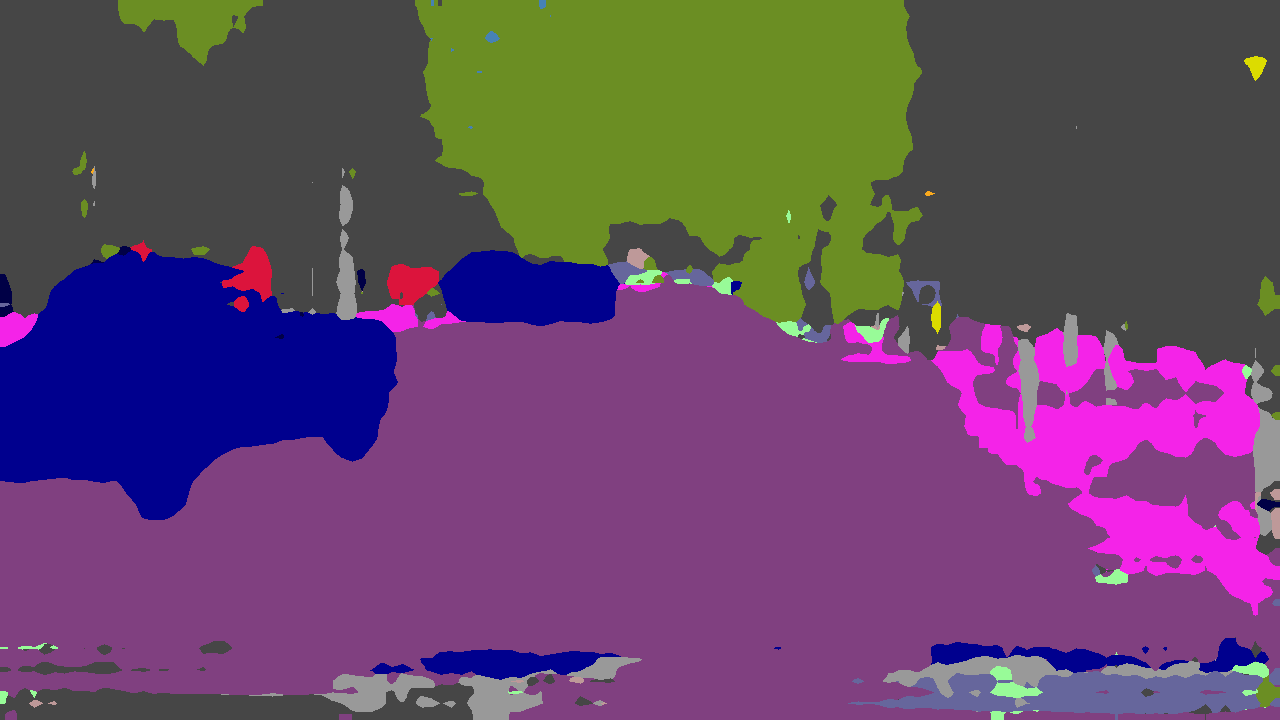

In [27]:
get_colorful_image

In [28]:
del img_var, output1, output2

# discriminator check

In [29]:
from model.discriminator import FCDiscriminator

In [30]:
# init D
model_D1 = FCDiscriminator(num_classes=args.num_classes)
model_D2 = FCDiscriminator(num_classes=args.num_classes)
# model_D1.train()
model_D1.cuda(args.gpu)
# model_D2.train()
model_D2.cuda(args.gpu)

FCDiscriminator(
  (conv1): Conv2d(19, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (classifier): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
)

In [31]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.
C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [32]:
pred_target1.shape

torch.Size([1, 19, 512, 1024])

In [33]:
F.softmax(pred_target1).shape

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


torch.Size([1, 19, 512, 1024])

In [34]:
output_d = model_D1(F.softmax(pred_target1))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [35]:
output_d.shape

torch.Size([1, 1, 16, 32])

In [36]:
del pred_target1, pred_target2, output_d

# test my discriminator

In [64]:
from model.xiao_discriminator import XiaoDiscriminator

In [66]:
from importlib import reload
reload(XiaoDiscriminator)


TypeError: reload() argument must be a module

In [59]:
# init D
model_D1 = XiaoDiscriminator(num_classes=args.num_classes)
model_D1.cuda(args.gpu)

XiaoDiscriminator(
  (conv1): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_resblock): ResBlock(
    (model): Sequential(
      (0): Conv2dBlock(
        (pad): ZeroPad2d(padding=(1, 1, 1, 1), value=0)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace)
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Conv2dBlock(
        (pad): ZeroPad2d(padding=(1, 1, 1, 1), value=0)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_resblock): ResBlock(
    (model): Sequential(
      (0): Conv2dBlock(
        (pad): ZeroPad2d(padding=(1, 1, 1, 1), value=0)
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [46]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [47]:
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [48]:
output_d = model_D1(F.softmax(pred_target1))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [49]:
output_d.shape

torch.Size([1, 1])

In [43]:
del pred_target1, pred_target2, output_d